<!-- import os<br>
import pandas as pd<br>
from PIL import Image<br>
import torch<br>
from torch.utils.data import Dataset, DataLoader<br>
from torchvision import transforms, models<br>
from ultralytics import YOLO -->

# PART 1 - Dataset Preparation<br>
class CattleDataset(Dataset):<br>
    def __init__(self, annotations_file, img_dir, transform=None):<br>
        self.annotations = pd.read_csv(annotations_file)<br>
        self.img_dir = img_dir<br>
        self.transform = transform

    def __len__(self):<br>
        return len(self.annotations)
    def __getitem__(self, idx):<br>
        img_filename = self.annotations.iloc[idx, 0]<br>
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert("RGB")
        # Fetch bounding boxes and class label<br>
        boxes = self.annotations.iloc[idx, 4:8].values.astype(float)<br>
        label = self.annotations.iloc[idx, 3]  # The class label
        if self.transform:<br>
            image = self.transform(image)
        label_tensor = torch.tensor(self.get_class_id(label), dtype=torch.long)
        return image, boxes, label_tensor
    def get_class_id(self, class_name):<br>
        class_map = {<br>
            'Infected_Foot_Image': 0,<br>
            'Mouth Disease Infected': 1,<br>
            'Normal_Healthy_Cow': 2,<br>
            'Normal_Mouth_Image': 3,<br>
            'lumpy skin': 4<br>
        }<br>
        return class_map.get(class_name, -1)
# Define transformations for the dataset<br>
transform = transforms.Compose([<br>
    transforms.Resize((224, 224)),  # Resize images for EfficientNet<br>
    transforms.ToTensor(),  # Convert images to tensors<br>
])
# Function to create DataLoader for training, validation, or testing<br>
def get_data_loader(annotations_file, img_dir, batch_size=32, shuffle=True, transform=None):<br>
    dataset = CattleDataset(annotations_file, img_dir, transform=transform)<br>
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
# PART 2 - Hybrid Model Definition<br>
class HybridYOLOEfficientNet(torch.nn.Module):<br>
    def __init__(self, yolo_model, efficientnet_model):<br>
        super(HybridYOLOEfficientNet, self).__init__()<br>
        self.yolo_model = yolo_model.model  # YOLO detection model<br>
        self.efficientnet = efficientnet_model.features  # EfficientNet feature extractor
        
         # Dynamically find the size of the feature output from EfficientNet
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features_size = self.efficientnet(dummy_input).view(1, -1).size(1)
        self.fc = torch.nn.Linear(features_size, 256)  # Fully connected layer<br>
        self.output = torch.nn.Linear(256, 5)  # For 5 classes
    def forward(self, x):<br>
        # YOLO forward pass (detect objects in the image)<br>
        detection_results = self.yolo_model(x)

        # EfficientNet forward pass (for classification)<br>
        features = self.efficientnet(x)<br>
        features = torch.flatten(features, 1)  # Flatten features from EfficientNet
        # Fully connected and output layers for classification<br>
        features = torch.relu(self.fc(features))  # Fully connected layer with ReLU<br>
        class_outputs = self.output(features)  # Classify the features
        return class_outputs, detection_results

# PART 3 - Training Function<br>
def train_model(model, data_loader, criterion, optimizer, device, epochs=3):<br>
    model.train()  # Set the model to training mode<br>
    for epoch in range(epochs):<br>
        running_loss = 0.0<br>
        print(f"Starting epoch {epoch+1}/{epochs}")<br>
        for batch_idx, (inputs, _, labels) in enumerate(data_loader):<br>
            inputs, labels = inputs.to(device), labels.to(device)
            
#             optimizer.zero_grad()  # Zero the parameter gradients
#             outputs, _ = model(inputs)  # Forward pass
            
#             loss = criterion(outputs, labels)  # Compute loss
#             loss.backward()  # Backpropagation
#             optimizer.step()  # Optimize the model
            running_loss += loss.item()
            
#             if batch_idx % 10 == 0:
#                 print(f"Batch {batch_idx}, Loss: {loss.item()}")

<!-- # PART 4 - Main Function to Initialize and Train the Model<br>
if __name__ == "__main__":<br>
    # Force the use of CPU<br>
    device = torch.device("cpu")<br>
    print(f"Using device: {device}")
    # Load pretrained YOLO model<br>
    yolo_model = YOLO("yolo11n.pt")<br>
    print(f"YOLO model loaded: {yolo_model}")
    # Load pretrained EfficientNet model<br>
    efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)<br>
    print(f"EfficientNet model loaded: {efficientnet_model}")
    # Initialize the hybrid model combining YOLO and EfficientNet<br>
    hybrid_model = HybridYOLOEfficientNet(yolo_model, efficientnet_model)<br>
    hybrid_model = hybrid_model.to(device)  # Move model to device
    print(f"Hybrid model initialized on {device}")
    # Define loss function and optimizer<br>
    criterion = torch.nn.CrossEntropyLoss()  # Use CrossEntropy for classification loss<br>
    optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.001)  # Adam optimizer
    # Create DataLoader for training data<br>
    train_loader = get_data_loader('train/_annotations.csv', 'train', transform=transform)
    # Check DataLoader by fetching a single batch<br>
    for images, boxes, labels in train_loader:<br>
        print(f"Batch loaded - Image shape: {images[0].shape}, Labels: {labels}")<br>
        break  # Stop after the first batch to ensure DataLoader is working
    # Train the hybrid model<br>
    train_model(hybrid_model, train_loader, criterion, optimizer, device, epochs=3) -->

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is installed and PyTorch detects the GPU
print(torch.cuda.current_device())  # Should print the current GPU device ID
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # Should print the GPU model name


True
0
NVIDIA GeForce RTX 4060 Laptop GPU


PART 1 - Dataset Preparation

In [3]:
class CattleDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, idx):
        img_filename = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert("RGB")

        # Only fetch the class label for classification
        label = self.annotations.iloc[idx, 3]  # The class label
        if self.transform:
            image = self.transform(image)
        label_tensor = torch.tensor(self.get_class_id(label), dtype=torch.long)
        return image, label_tensor
    def get_class_id(self, class_name):
        class_map = {
            'Infected_Foot_Image': 0,
            'Mouth Disease Infected': 1,
            'Normal_Healthy_Cow': 2,
            'Normal_Mouth_Image': 3,
            'lumpy skin': 4
        }
        return class_map.get(class_name, -1)

Define transformations for the dataset

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for EfficientNet
    transforms.ToTensor(),  # Convert images to tensors
])

def get_data_loader(annotations_file, img_dir, batch_size=32, shuffle=True, transform=None):
    dataset = CattleDataset(annotations_file, img_dir, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

Function to create DataLoader for training, validation, or testing

PART 2 - EfficientNet Model Definition

In [5]:
class EfficientNetClassifier(torch.nn.Module):
    def __init__(self, efficientnet_model):
        super(EfficientNetClassifier, self).__init__()
        self.efficientnet = efficientnet_model.features  # EfficientNet feature extractor
        
        # Dynamically find the size of the feature output from EfficientNet
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features_size = self.efficientnet(dummy_input).view(1, -1).size(1)
        self.fc = torch.nn.Linear(features_size, 256)  # Fully connected layer
        self.output = torch.nn.Linear(256, 5)  # For 5 classes
    def forward(self, x):
        # EfficientNet forward pass for classification
        features = self.efficientnet(x)
        features = torch.flatten(features, 1)  # Flatten features from EfficientNet

        # Fully connected and output layers for classification
        features = torch.relu(self.fc(features))  # Fully connected layer with ReLU
        class_outputs = self.output(features)  # Classify the features
        return class_outputs

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

PART 3 - Training and Evaluation Functions

In [7]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Training Function
def train_model(model, train_loader, criterion, optimizer, device, epochs=10, batch_interval=10):
    model.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        batch_losses = []
        correct_predictions = 0
        total_predictions = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            batch_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            # Display progress for every 10 batches
            if (batch_idx + 1) % batch_interval == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Calculate epoch loss and accuracy
        epoch_loss = sum(batch_losses) / len(batch_losses)
        epoch_accuracy = correct_predictions / total_predictions
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] - Average Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Plot training loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), epoch_losses, label="Loss", color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), epoch_accuracies, label="Accuracy", color='blue')
    plt.title("Training Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [8]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Collect labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


PART 4 - Main Function to Initialize, Train, and Evaluate the Model

Using device: cuda

Starting Training...

Epoch [1/30], Batch [10/1045], Loss: 2.2037
Epoch [1/30], Batch [20/1045], Loss: 1.0482
Epoch [1/30], Batch [30/1045], Loss: 0.9608
Epoch [1/30], Batch [40/1045], Loss: 0.5265
Epoch [1/30], Batch [50/1045], Loss: 0.8103
Epoch [1/30], Batch [60/1045], Loss: 1.5564
Epoch [1/30], Batch [70/1045], Loss: 1.0247
Epoch [1/30], Batch [80/1045], Loss: 0.6737
Epoch [1/30], Batch [90/1045], Loss: 0.7322
Epoch [1/30], Batch [100/1045], Loss: 0.9456
Epoch [1/30], Batch [110/1045], Loss: 0.7243
Epoch [1/30], Batch [120/1045], Loss: 1.0279
Epoch [1/30], Batch [130/1045], Loss: 0.8892
Epoch [1/30], Batch [140/1045], Loss: 0.9371
Epoch [1/30], Batch [150/1045], Loss: 0.8489
Epoch [1/30], Batch [160/1045], Loss: 0.8017
Epoch [1/30], Batch [170/1045], Loss: 0.7032
Epoch [1/30], Batch [180/1045], Loss: 0.8375
Epoch [1/30], Batch [190/1045], Loss: 0.4971
Epoch [1/30], Batch [200/1045], Loss: 1.2568
Epoch [1/30], Batch [210/1045], Loss: 0.7865
Epoch [1/30], Batch [2

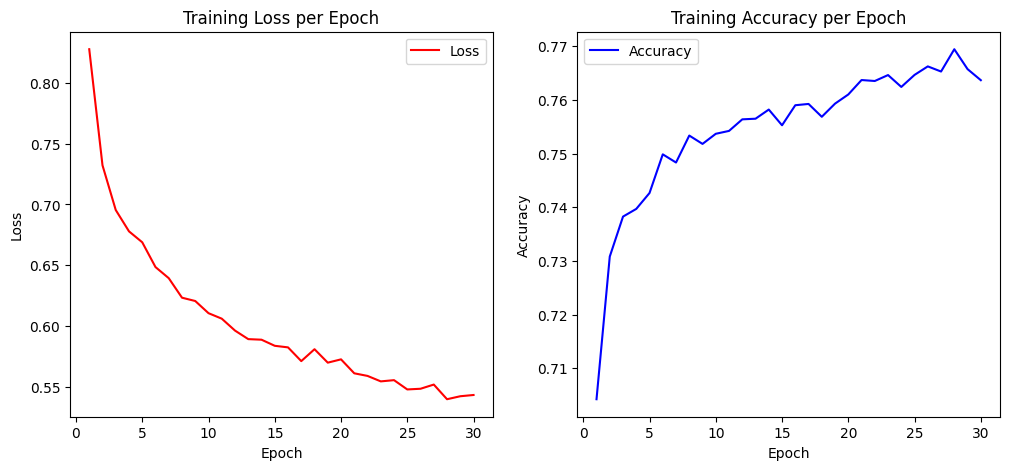


Evaluating the Model...

Test Accuracy: 0.9527
Precision (Weighted): 0.9561
Recall (Weighted): 0.9527
F1-Score (Weighted): 0.9534


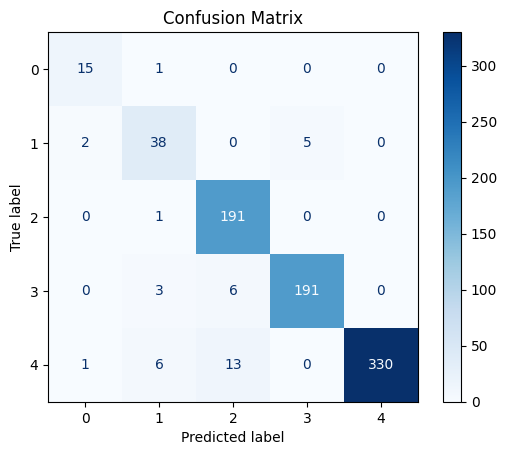

In [9]:
if __name__ == "__main__":
    # Use GPU if available, otherwise fallback to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load pretrained EfficientNet model
    efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    efficientnet_classifier = EfficientNetClassifier(efficientnet_model)
    efficientnet_classifier = efficientnet_classifier.to(device)

    # Loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(efficientnet_classifier.parameters(), lr=0.001)

    # Data loaders
    train_loader = get_data_loader('train/_annotations.csv', 'train', transform=transform)
    test_loader = get_data_loader('test/_annotations.csv', 'test', transform=transform, shuffle=False)

    # Train the model
    print("\nStarting Training...\n")
    train_model(efficientnet_classifier, train_loader, criterion, optimizer, device, epochs=30)

    # Evaluate the model
    print("\nEvaluating the Model...\n")
    evaluate_model(efficientnet_classifier, test_loader, device)
